In [2]:
import pandas as pd
import sklearn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)


In [3]:
working_dir = ''
output_dir = ''
train_data = pd.read_csv(working_dir + 'train.csv')
test_data = pd.read_csv(working_dir + 'test.csv')
data_dict = pd.read_csv(working_dir + 'data_dictionary.csv')

In [4]:
train_data = train_data.drop(columns='id')

In [5]:
# Encoding string data
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(['Spring', 'Summer', 'Fall', 'Winter', 'missing'])

season_cols = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season',
       'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 'PAQ_A-Season',
       'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']

for col in season_cols:
    train_data[col] = train_data[col].fillna('missing')
    train_data[col] = le.transform(train_data[col])

In [6]:
# Trimming data by SII and PCIAT
train_data = train_data[train_data['sii'].isnull() == False]

In [7]:
pciat_columns = ['PCIAT-Season', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 
                 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 
                 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 
                 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 
                 'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total']

In [8]:
# Dropoping columns with False PCIAT results
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
train_data.loc[train_data['PCIAT-PCIAT_Total'] == 0]

train_data = train_data.drop(index=train_data.loc[train_data['PCIAT-PCIAT_Total'] == 0].index)

In [9]:
# Drop rows with missing PCIAT
for col in pciat_columns:
    train_data = train_data.drop(index=train_data.loc[train_data[col].isnull()].index)

In [10]:
# Drop data with high missing ratio
for col in train_data.columns:
    percent_missing = np.round(train_data[col].isnull().sum() / len(train_data) * 100, 2)
    print(f"{col.ljust(30)} {str(percent_missing).rjust(6)}%")

Basic_Demos-Enroll_Season         0.0%
Basic_Demos-Age                   0.0%
Basic_Demos-Sex                   0.0%
CGAS-Season                       0.0%
CGAS-CGAS_Score                  14.0%
Physical-Season                   0.0%
Physical-BMI                     7.99%
Physical-Height                  7.87%
Physical-Weight                  6.39%
Physical-Waist_Circumference    83.21%
Physical-Diastolic_BP            9.69%
Physical-HeartRate               9.39%
Physical-Systolic_BP             9.69%
Fitness_Endurance-Season          0.0%
Fitness_Endurance-Max_Stage     74.11%
Fitness_Endurance-Time_Mins     74.24%
Fitness_Endurance-Time_Sec      74.24%
FGC-Season                        0.0%
FGC-FGC_CU                      31.05%
FGC-FGC_CU_Zone                 32.32%
FGC-FGC_GSND                    65.82%
FGC-FGC_GSND_Zone               66.07%
FGC-FGC_GSD                     65.82%
FGC-FGC_GSD_Zone                66.07%
FGC-FGC_PU                      31.39%
FGC-FGC_PU_Zone          

In [11]:
high_miss_ratio = ['Physical-Waist_Circumference', 'Fitness_Endurance-Season',
                   'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins',
                   'Fitness_Endurance-Time_Sec', 'FGC-FGC_GSND',
                   'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone']
# Drop PAQ_C-PAQ_C_Total because this is the score for children and the PAQ_A-PAQ_A_Total is for adolescent which was removed

train_data.drop(columns=high_miss_ratio, inplace=True)

In [12]:
# Handling noise
def plotFeaturesKDE(df):
    fig, axes = plt.subplots(20, 4, figsize=(25,50))
    axes = axes.flatten()

    for i, col in enumerate(df.columns):
        sns.histplot(df[col], label=col, ax=axes[i])
        
    for j in range(len(df.columns), len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

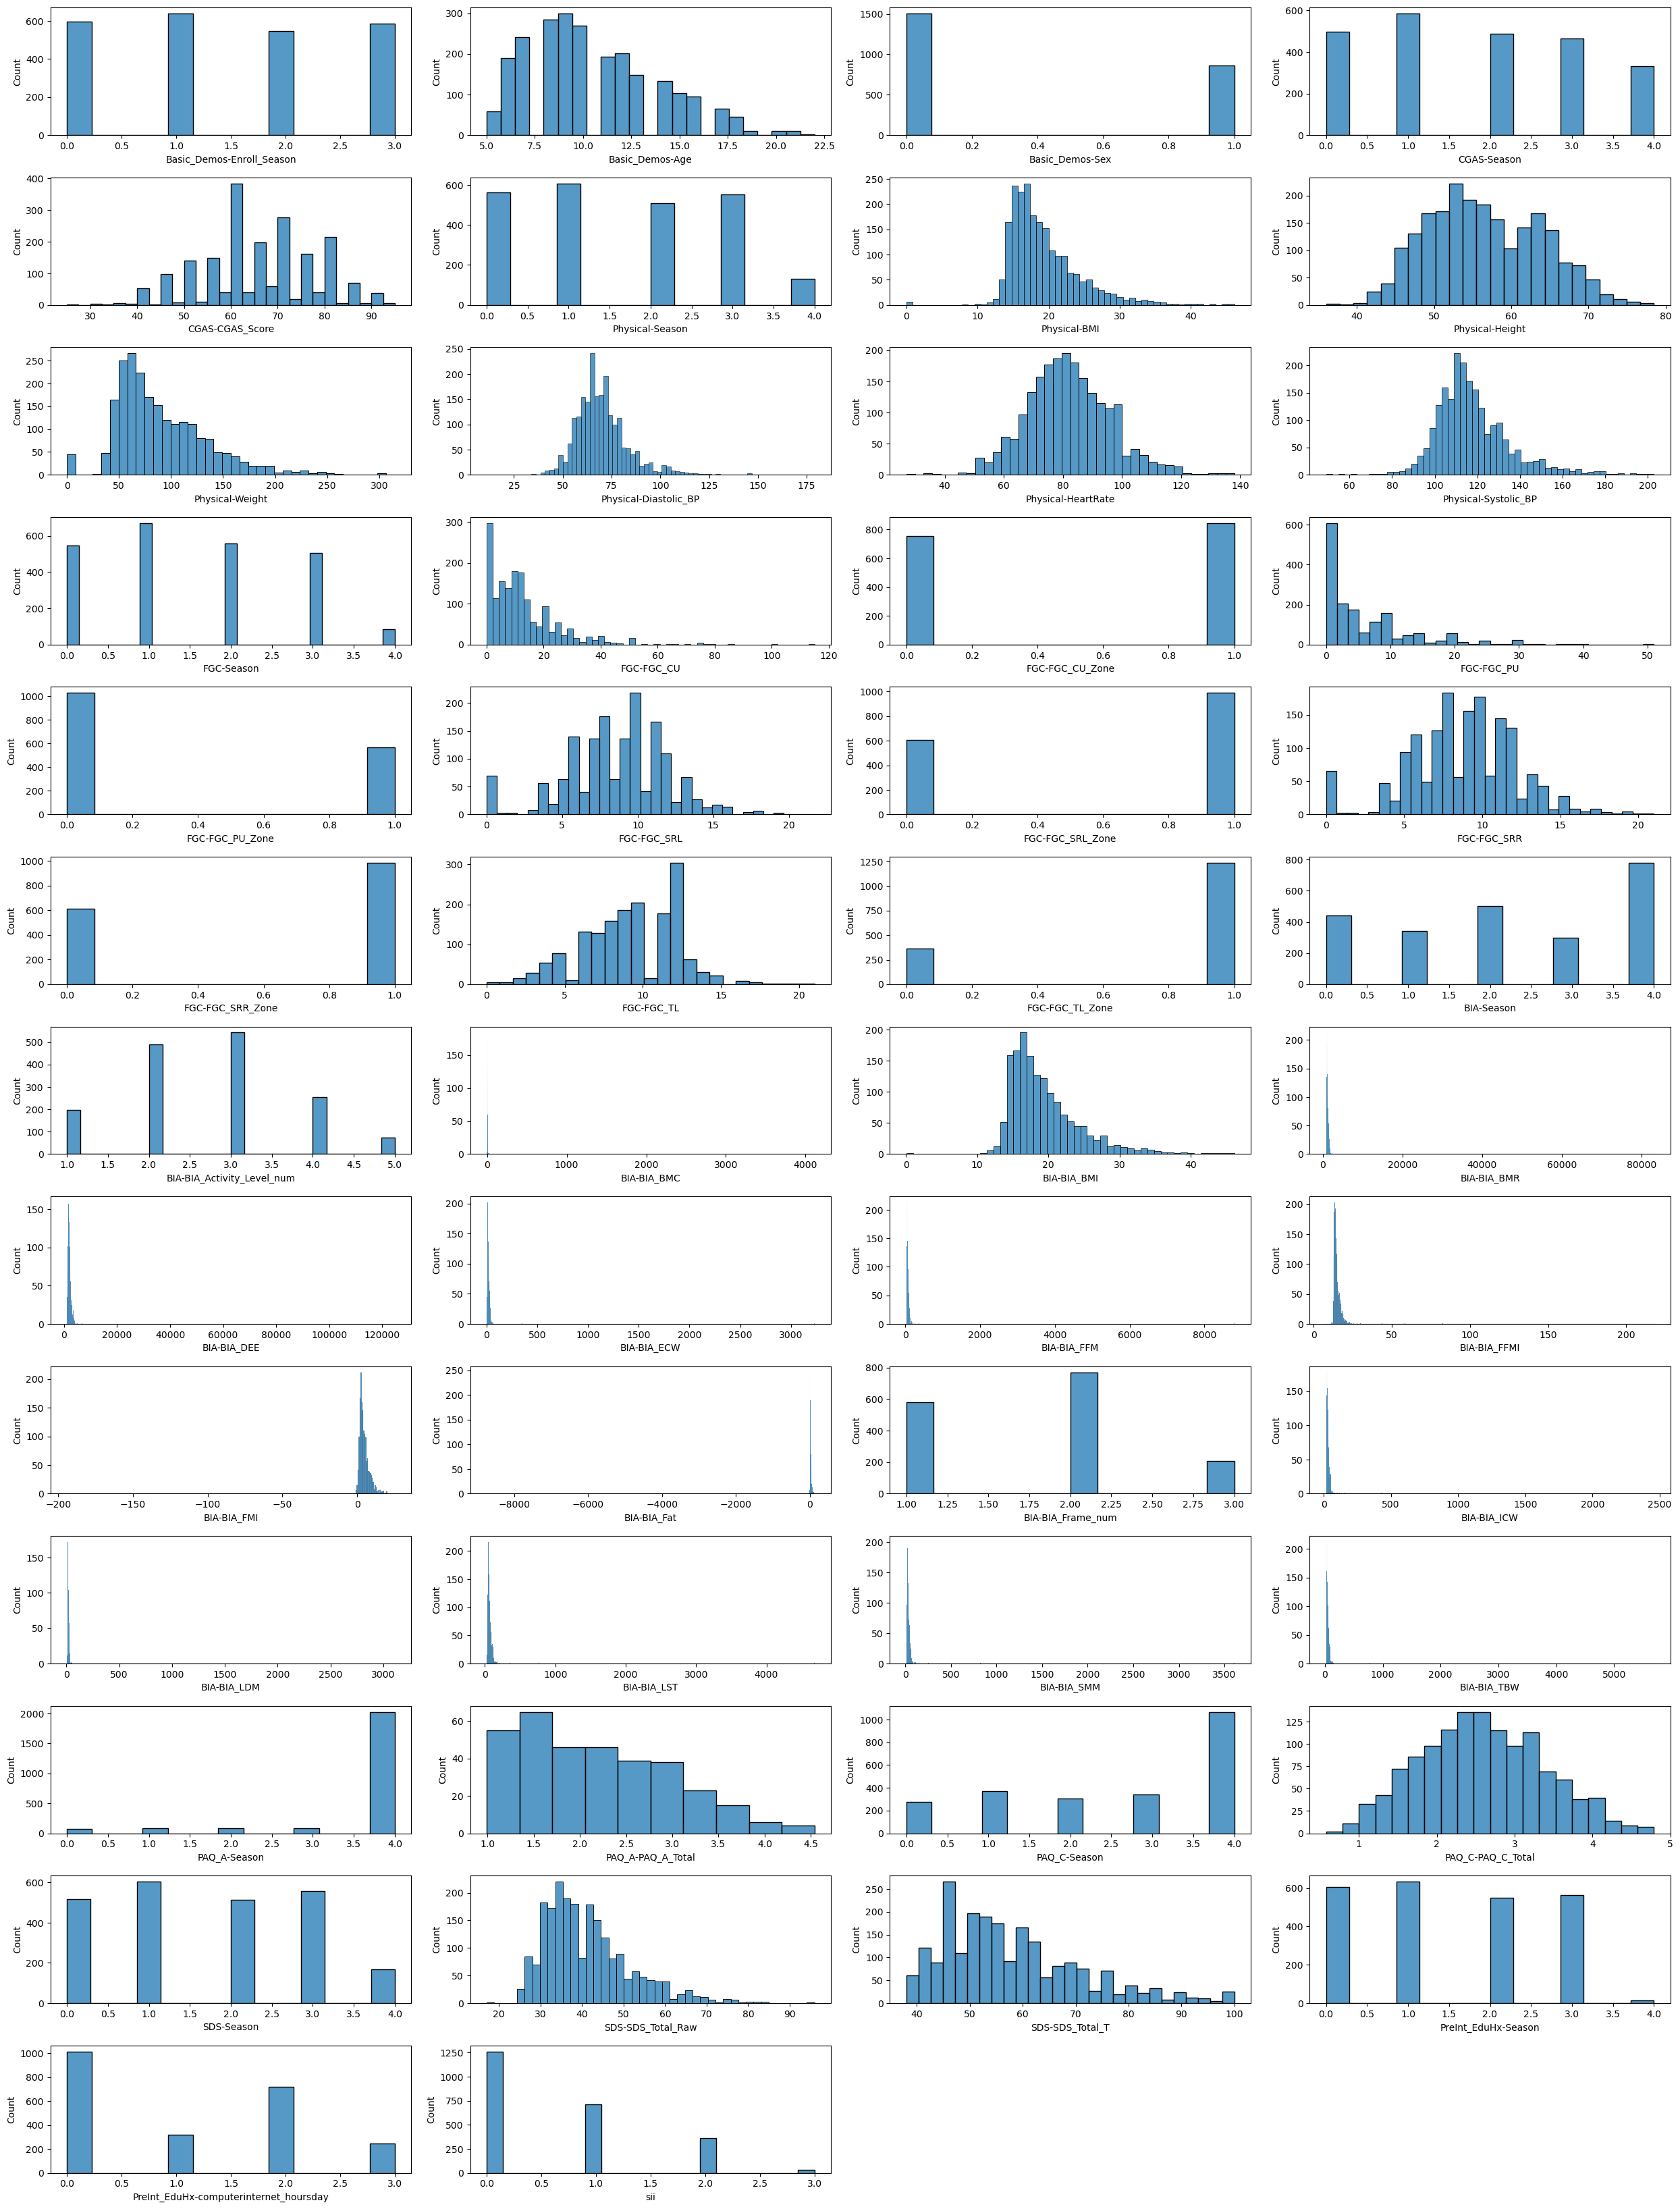

In [13]:
plotFeaturesKDE(train_data.drop(columns=pciat_columns))

In [14]:
# Filtering out obvious false data like weight = 0
# Physical weight
train_data.loc[train_data['Physical-Weight']==0] # Drop
train_data.drop(index=train_data.loc[train_data['Physical-Weight']==0].index, inplace=True)

train_data.drop(index=train_data.loc[train_data['Physical-BMI']==0].index, inplace=True)

train_data.drop(index=train_data.loc[train_data['BIA-BIA_BMI']==0].index, inplace=True)
# train_data.loc[train_data['FGC-FGC_SRR']==0] # Keep because this indicates unhealthy participants

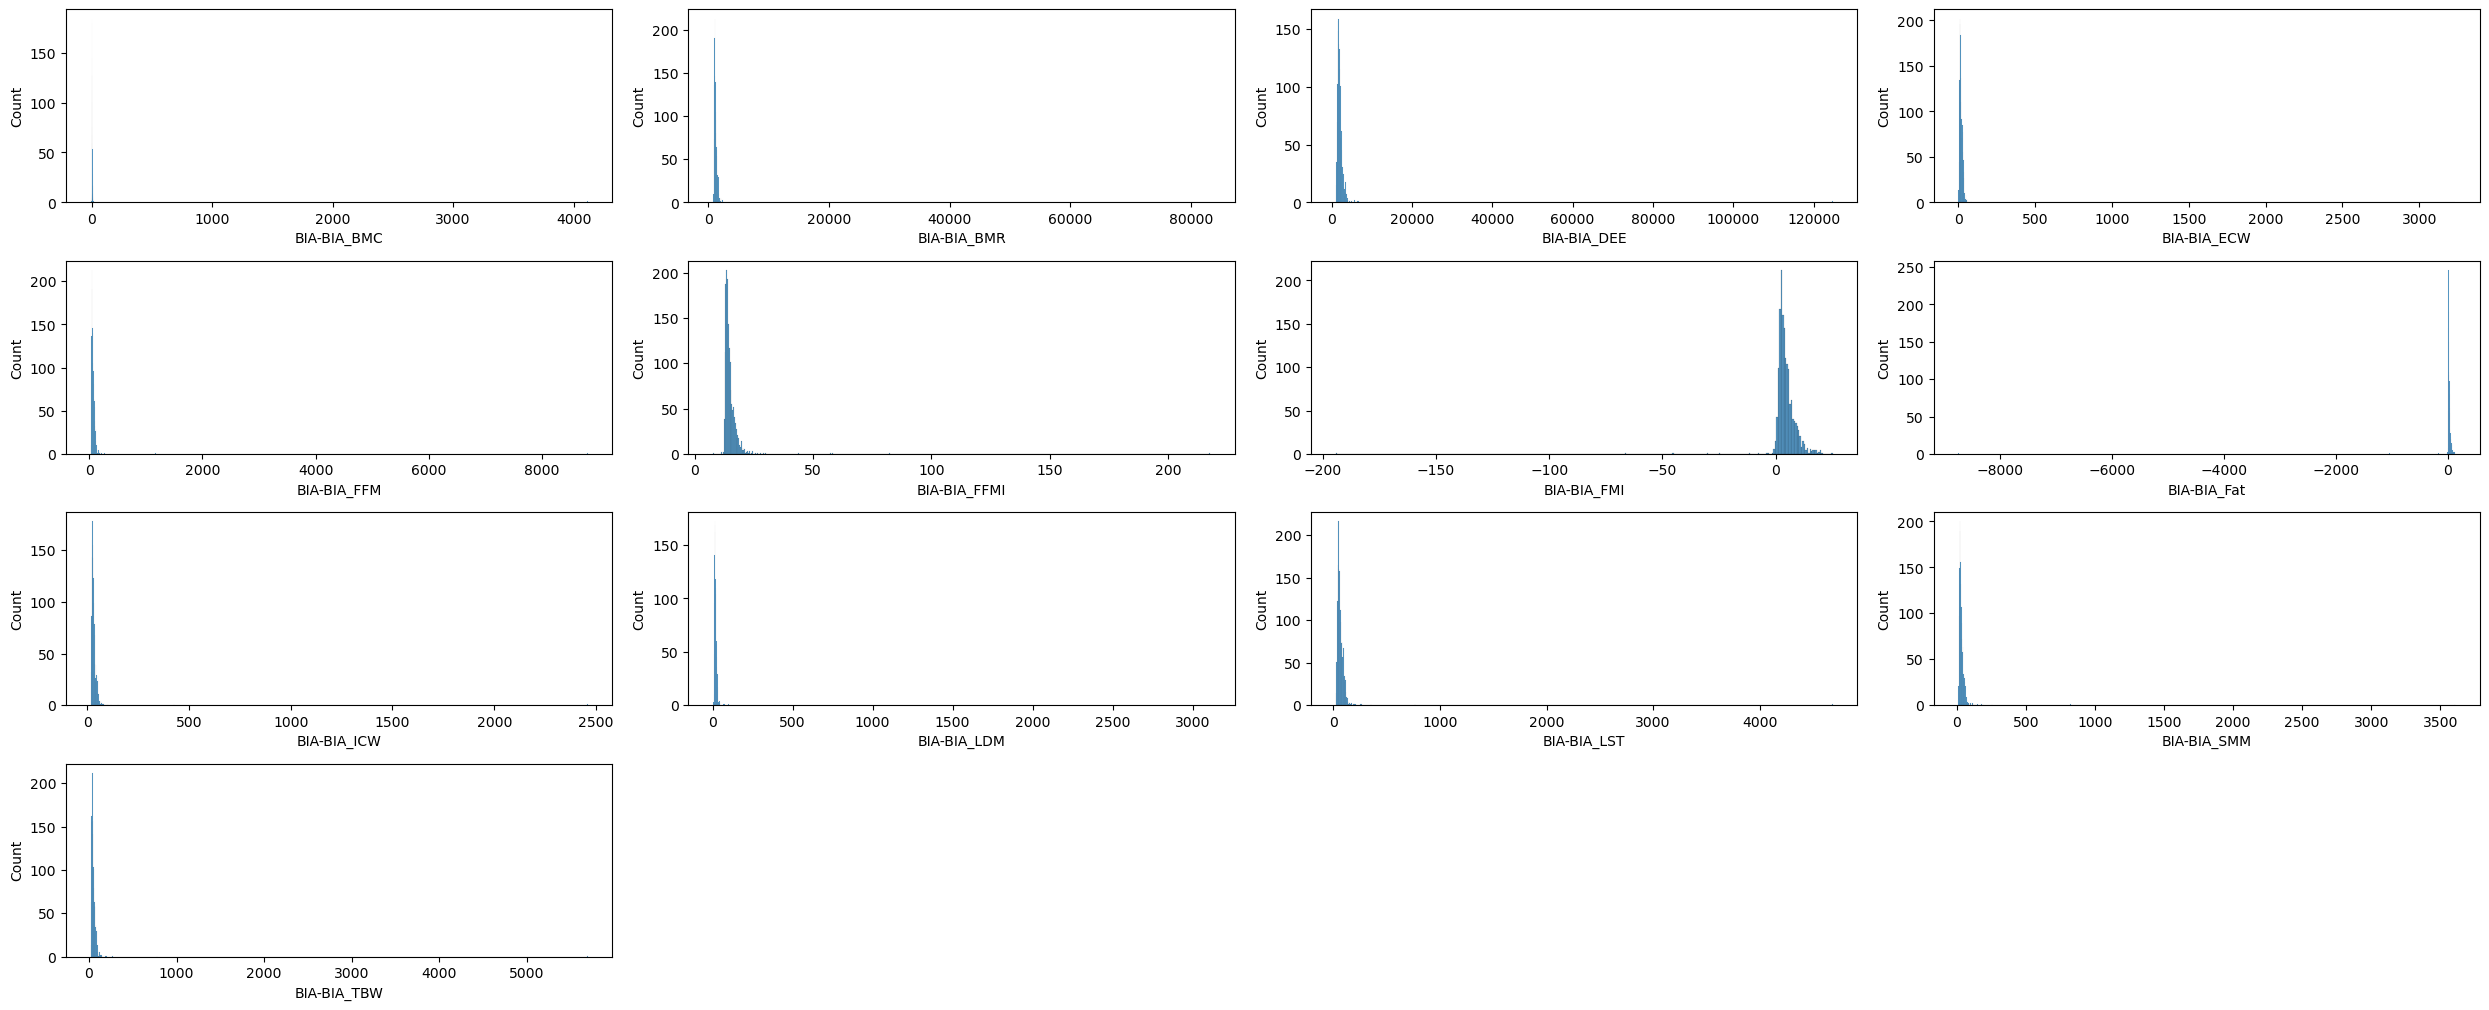

In [15]:
# Handling skewed data
skewed_data = ['BIA-BIA_BMC', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 
               'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW']

plotFeaturesKDE(train_data[skewed_data])

In [16]:
feature_cap = {}

for col in skewed_data:
    feature_cap[col] = {
        'lower': train_data[col].quantile(0.005),
        'upper': train_data[col].quantile(0.995)
    }

    train_data[col] = train_data[col].clip(feature_cap[col]['lower'], feature_cap[col]['upper'])

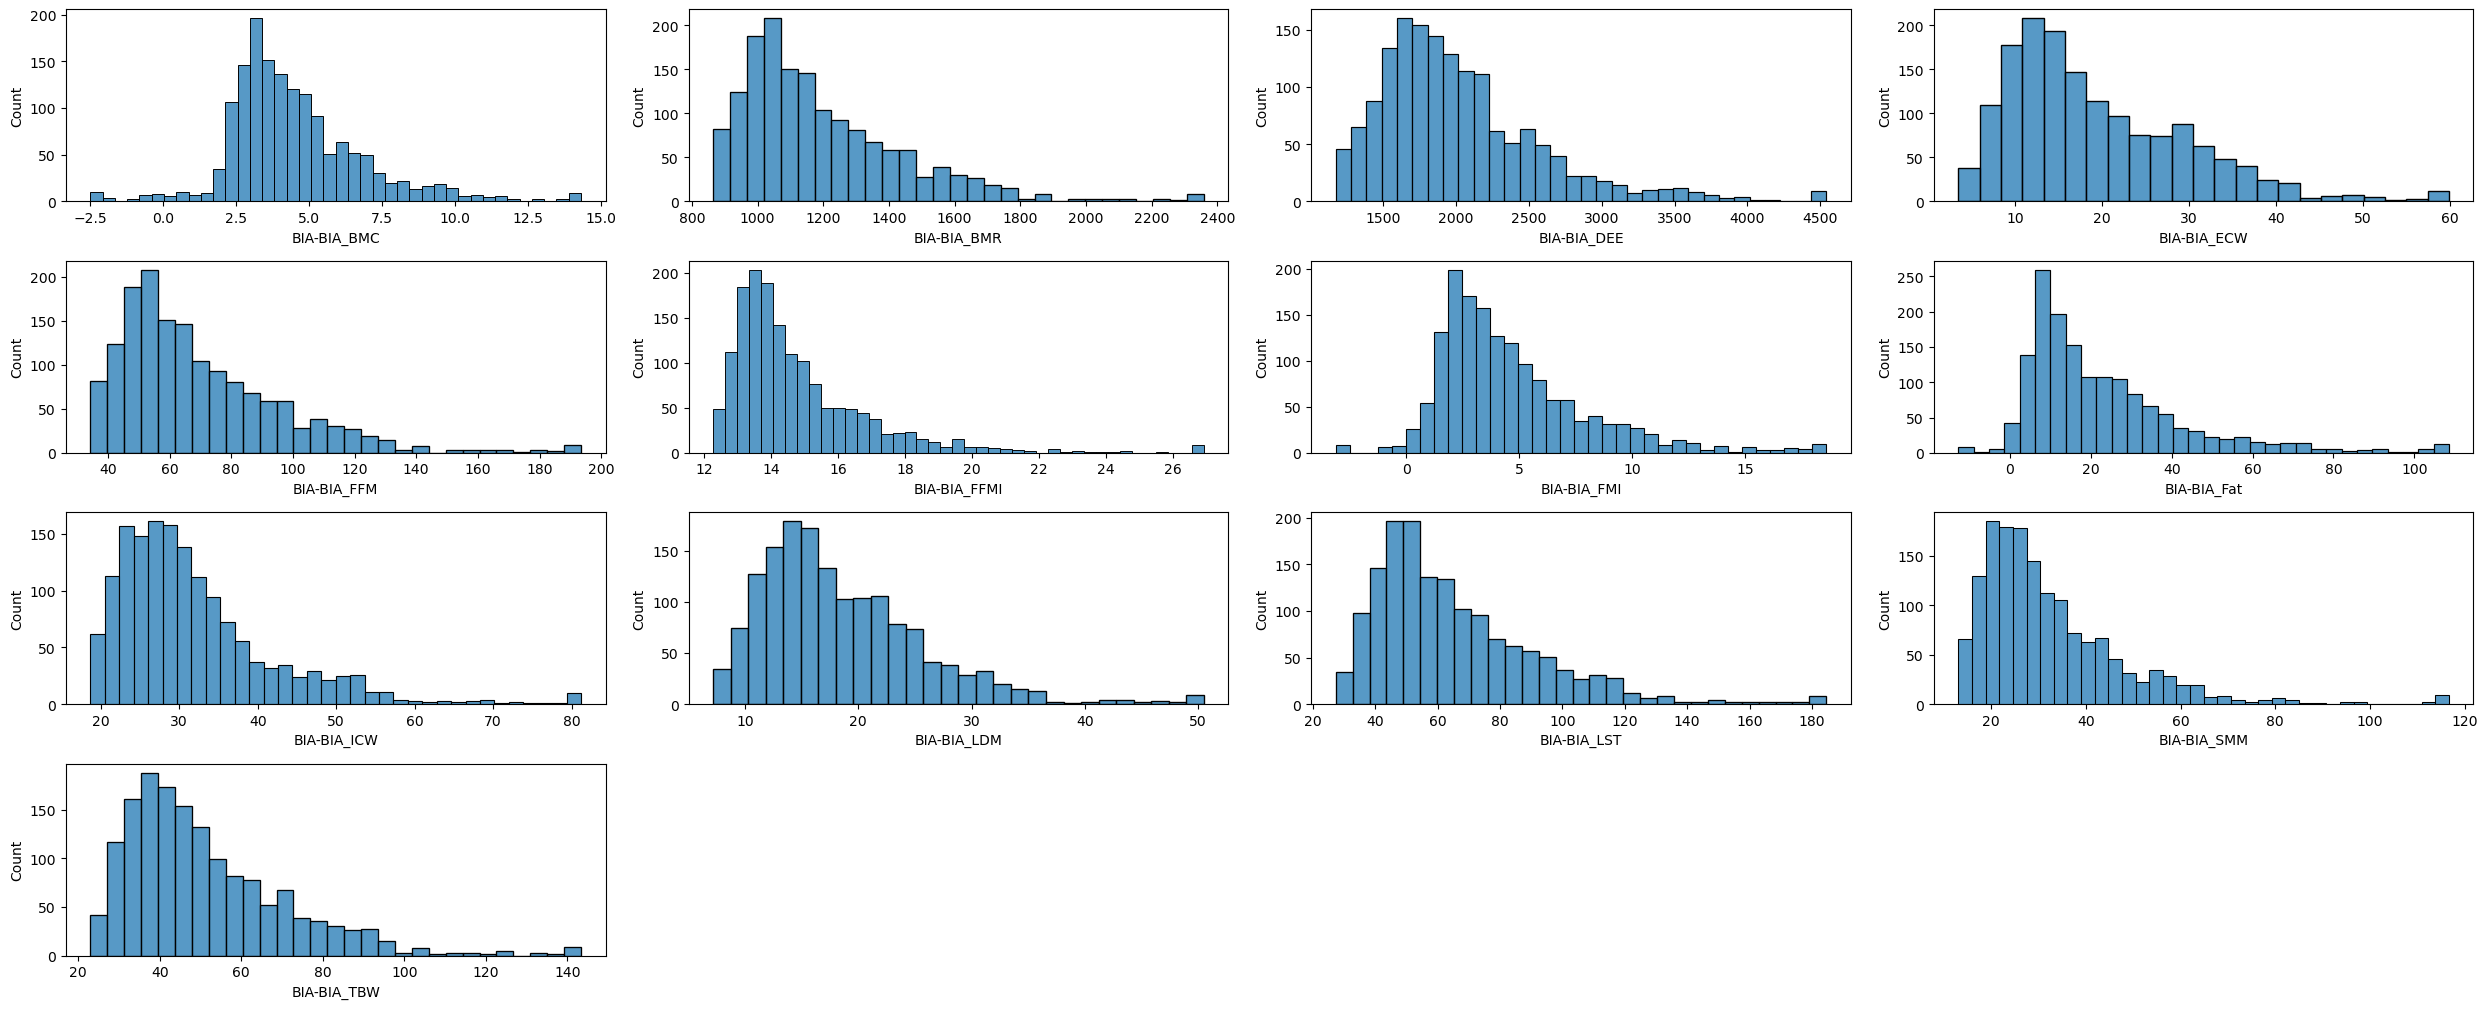

In [17]:
plotFeaturesKDE(train_data[skewed_data])

<h1>Feature engineering</h1>

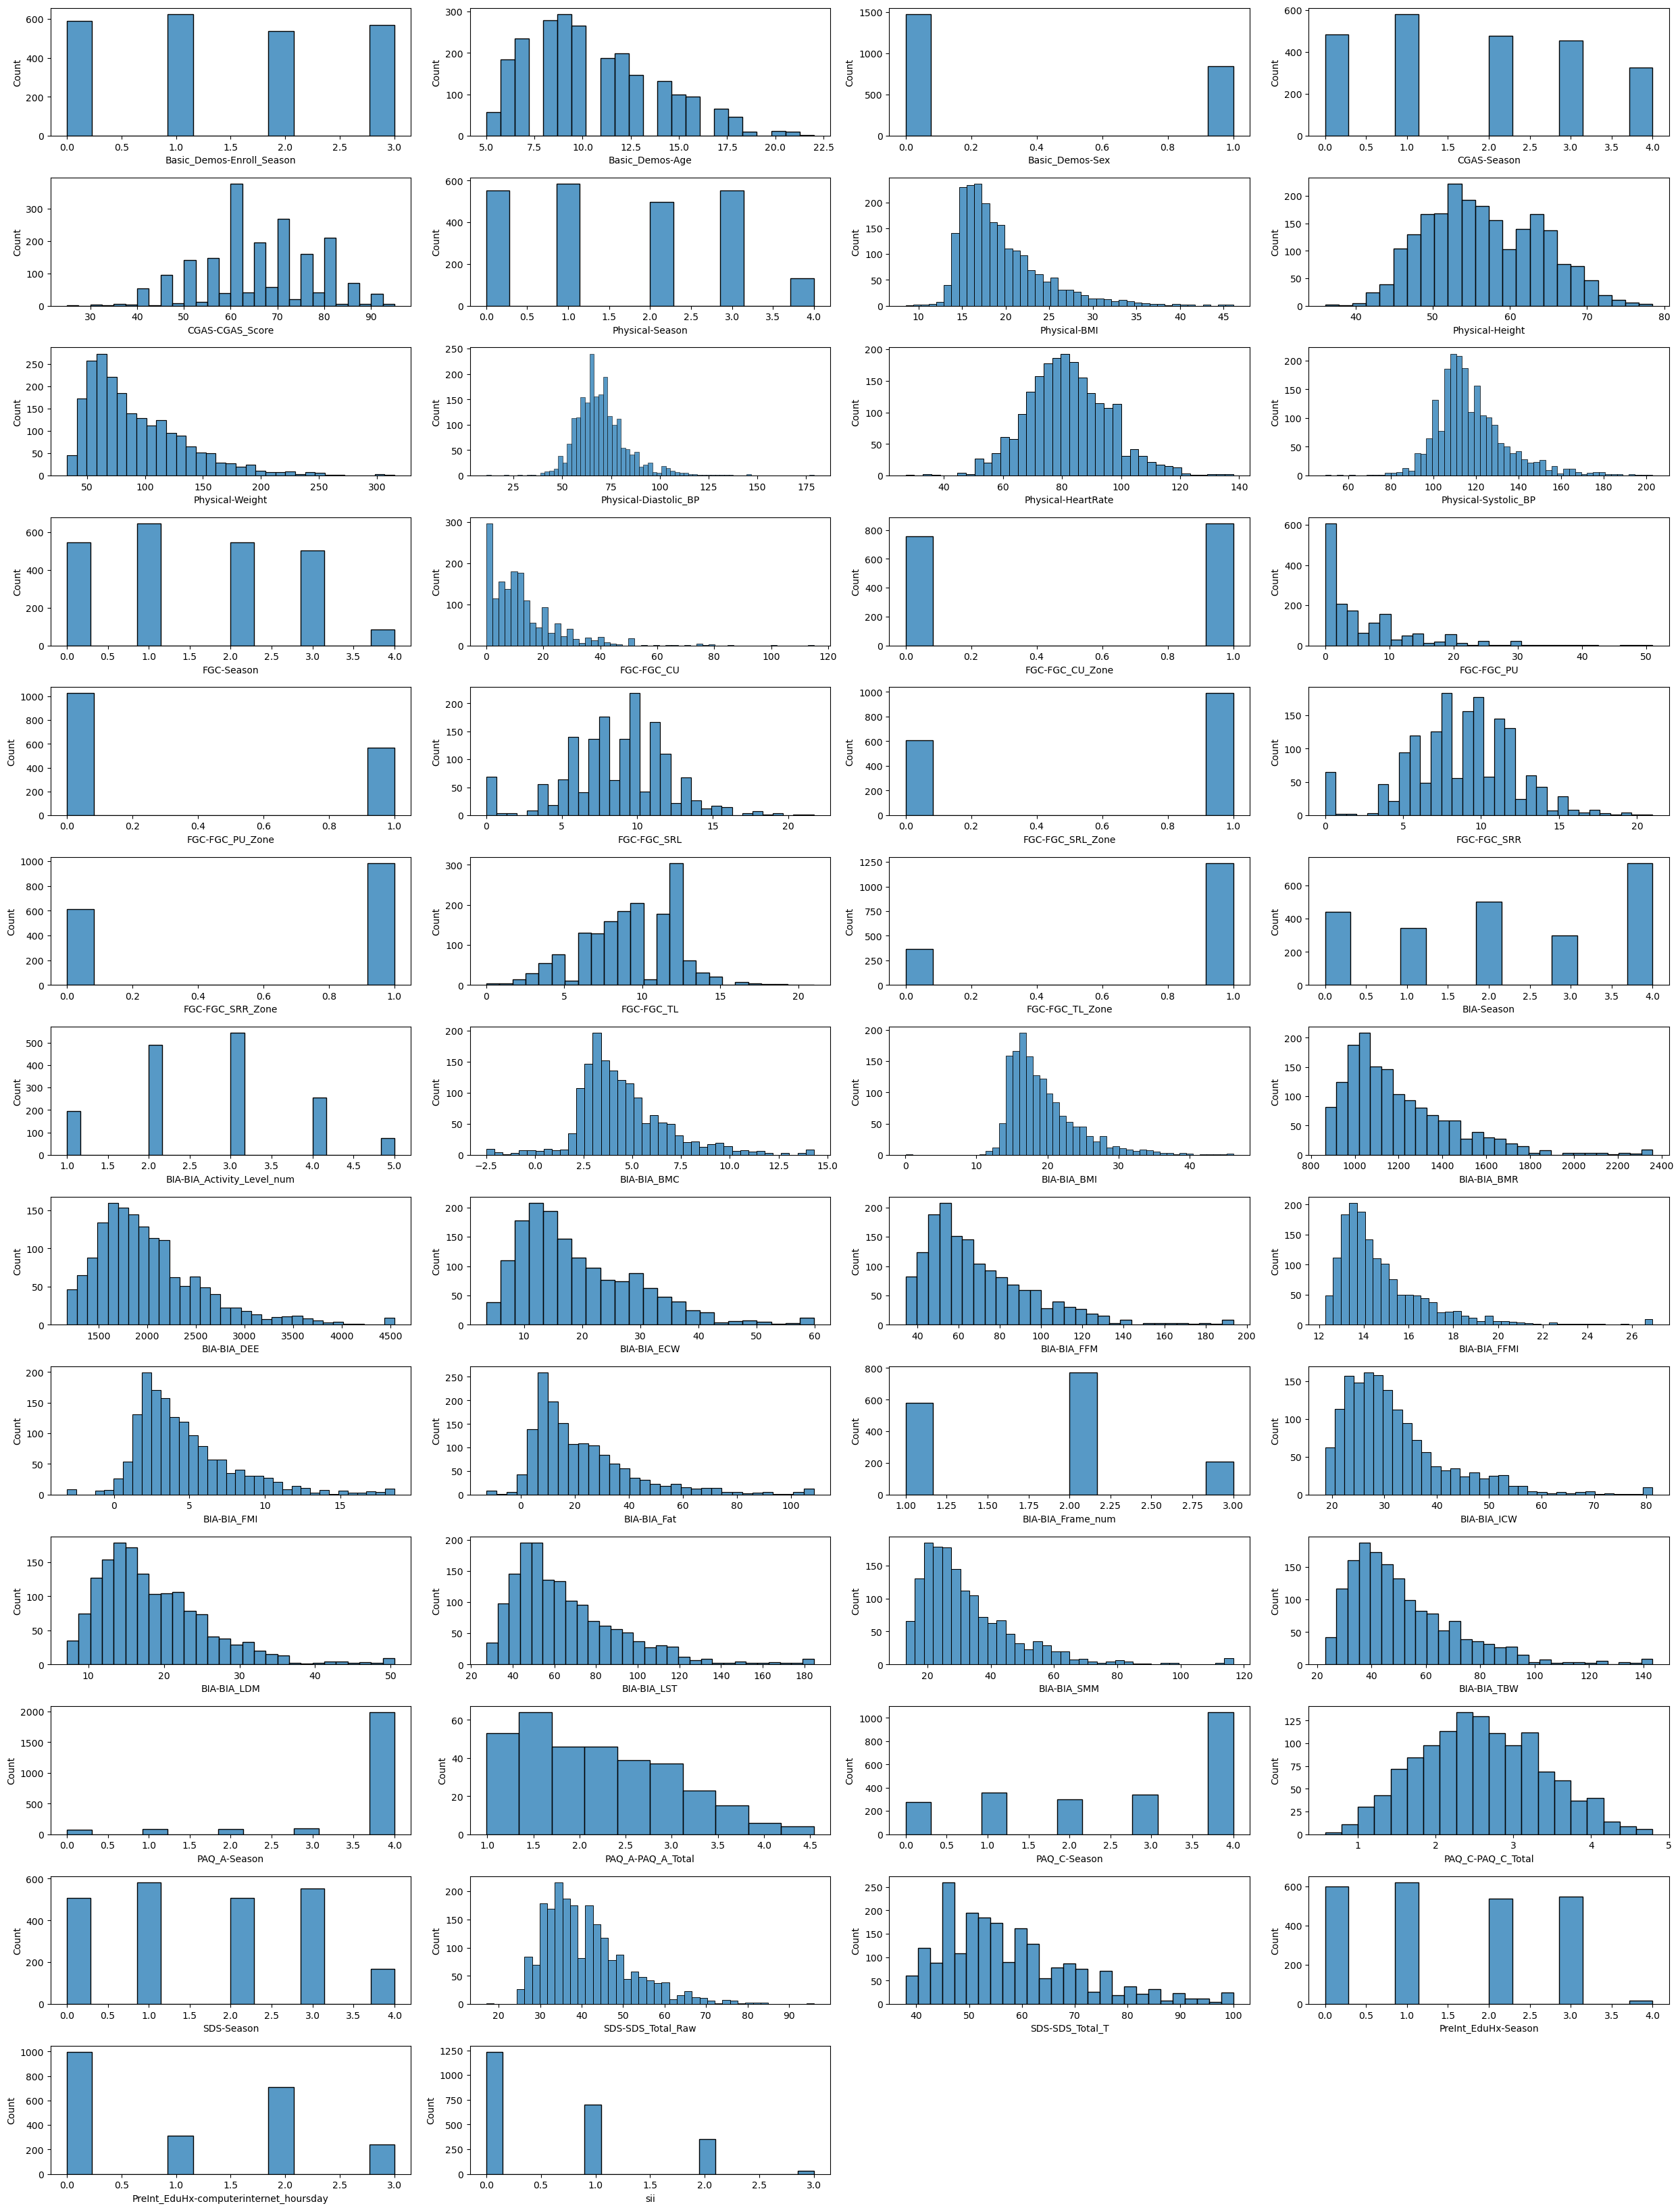

In [18]:
plotFeaturesKDE(train_data.drop(columns=pciat_columns))

<Axes: >

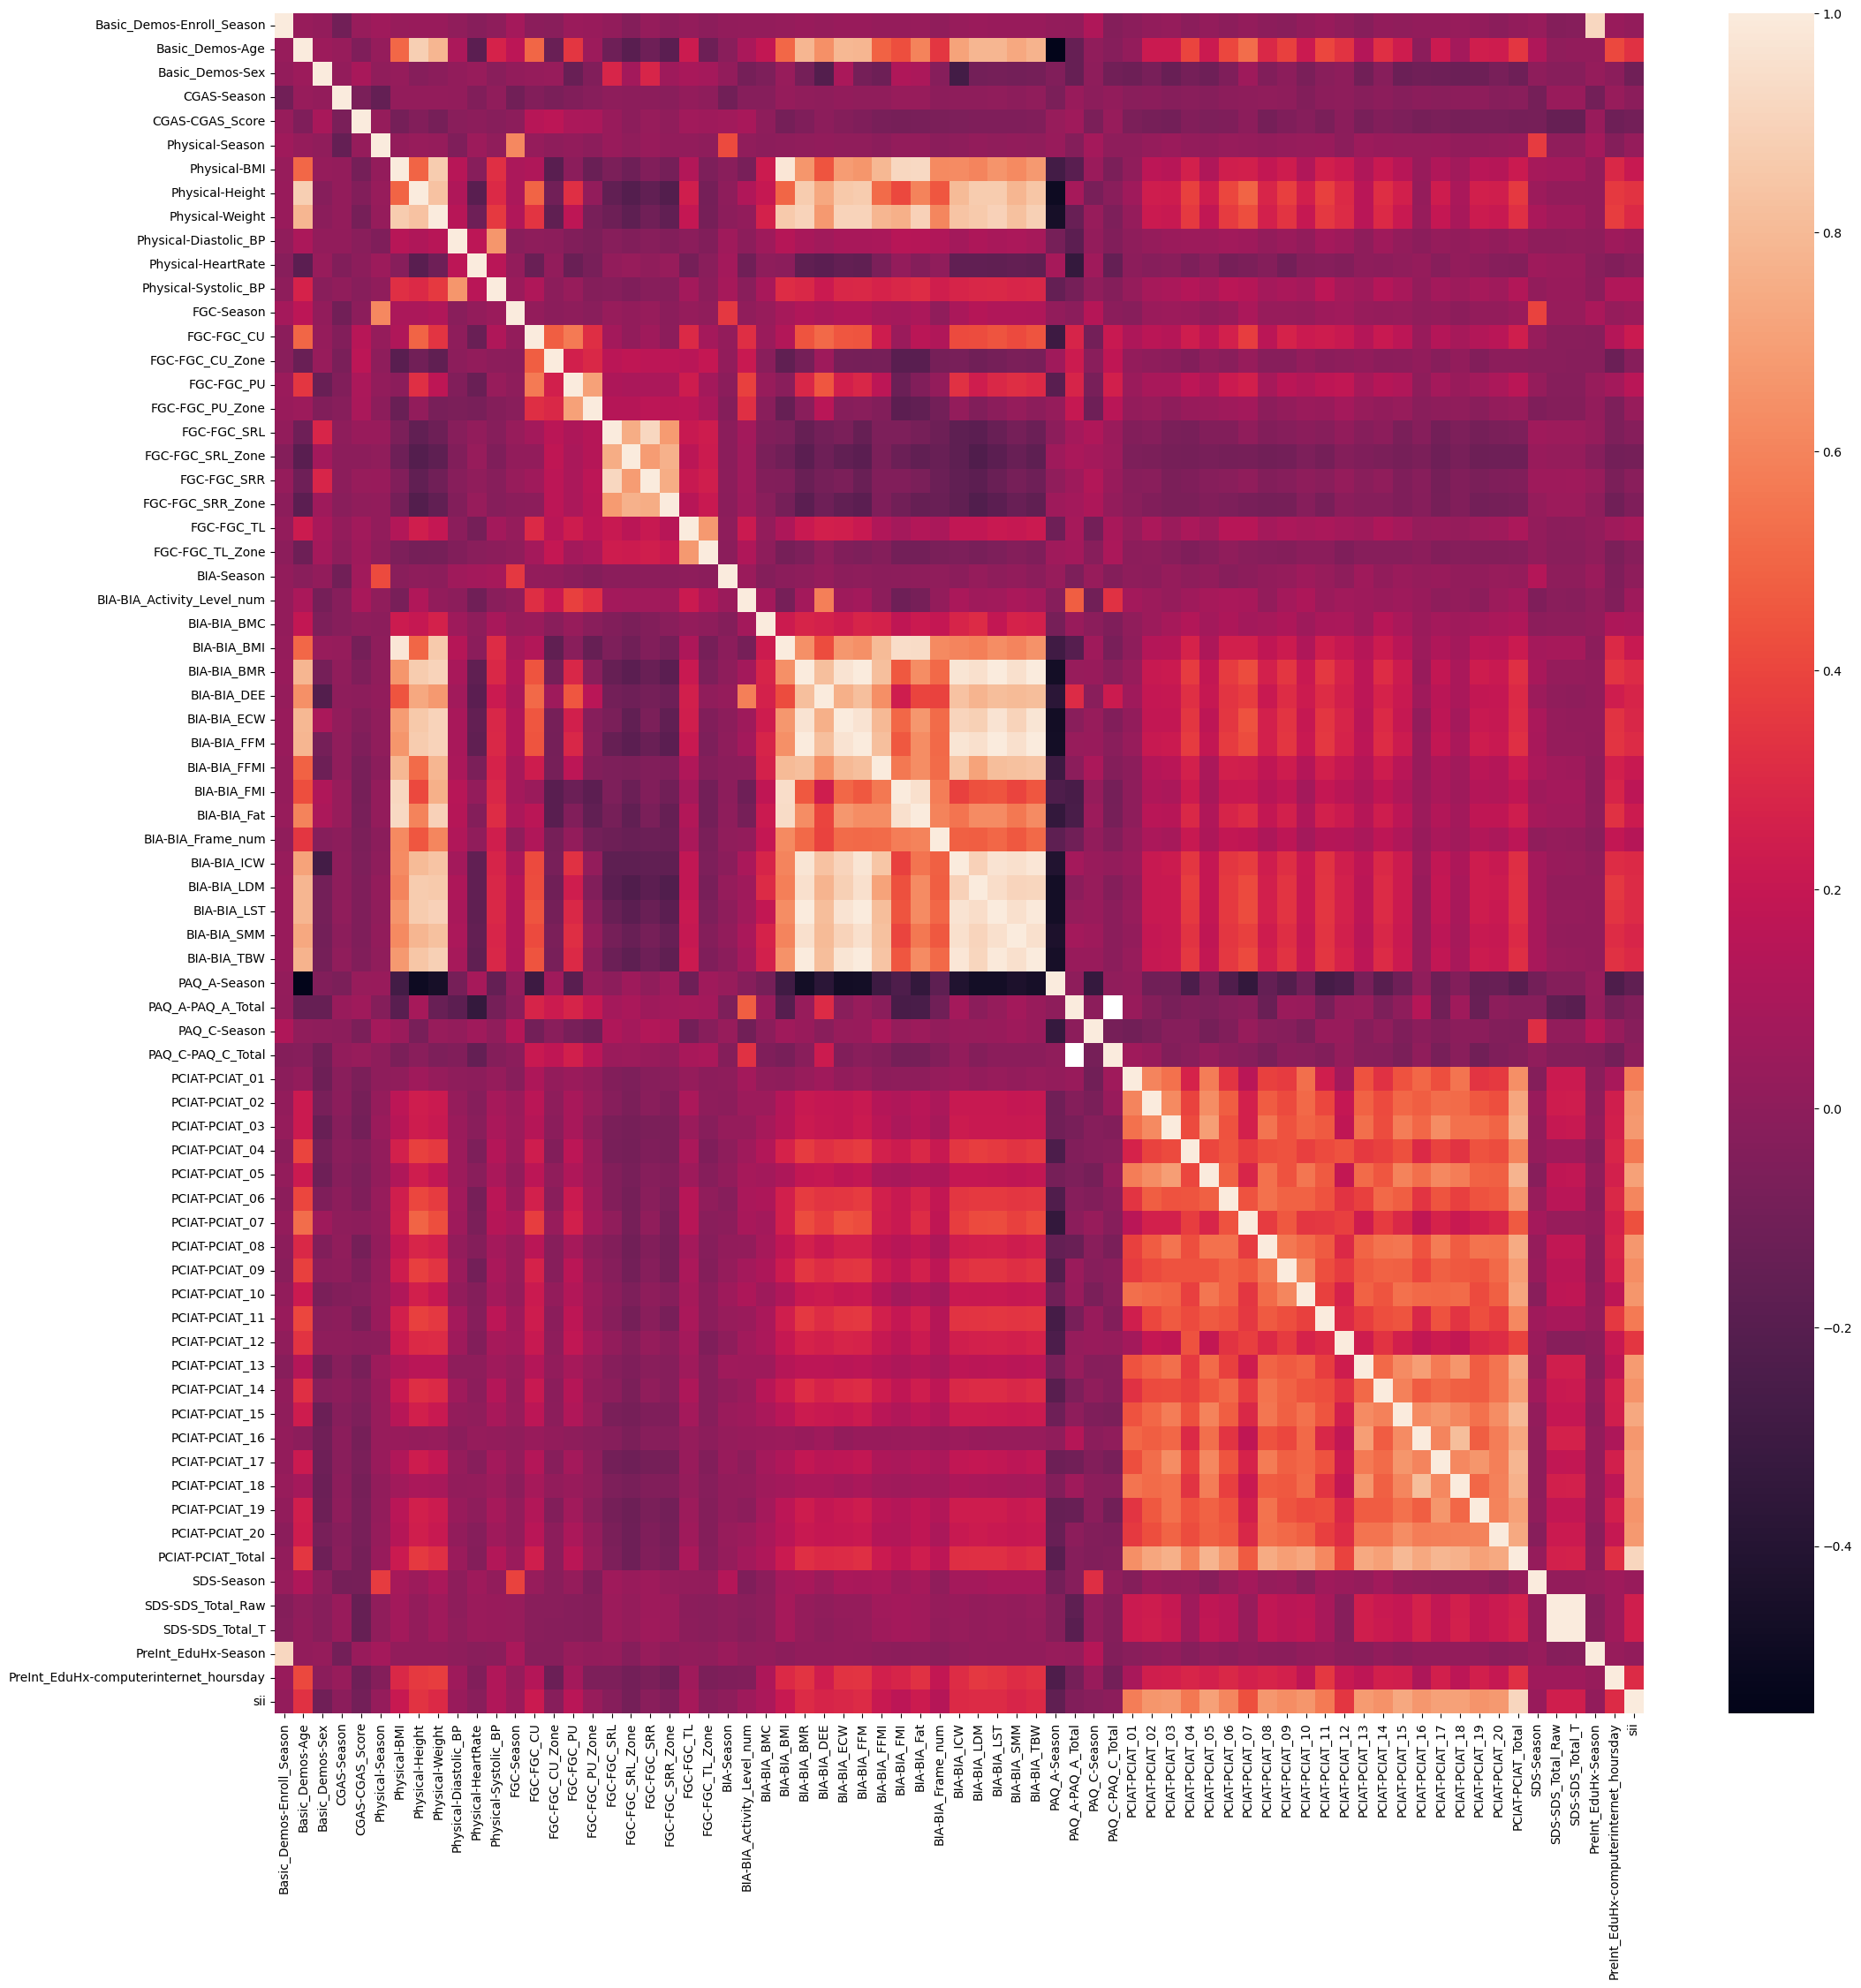

In [24]:
plt.figure(figsize=(25,25))
sns.heatmap(train_data.corr(numeric_only=True))

In [18]:
filtered_data = data_dict[data_dict['Field'].isin(train_data.columns)]

grouped_data = filtered_data.groupby('Instrument')

for group_name, group_values in grouped_data:
    print(f"Group Name: {group_name}")
    print("Field and Description:")
    field_description_pairs = list(zip(group_values['Field'], group_values['Description']))
    for field, description in field_description_pairs:
        print(f"  - {field}: {description}")
    
    print("\n")


Group Name: Bio-electric Impedance Analysis
Field and Description:
  - BIA-Season: Season of participation
  - BIA-BIA_Activity_Level_num: Activity Level
  - BIA-BIA_BMC: Bone Mineral Content
  - BIA-BIA_BMI: Body Mass Index
  - BIA-BIA_BMR: Basal Metabolic Rate
  - BIA-BIA_DEE: Daily Energy Expenditure
  - BIA-BIA_ECW: Extracellular Water
  - BIA-BIA_FFM: Fat Free Mass
  - BIA-BIA_FFMI: Fat Free Mass Index
  - BIA-BIA_FMI: Fat Mass Index
  - BIA-BIA_Fat: Body Fat Percentage
  - BIA-BIA_Frame_num: Body Frame
  - BIA-BIA_ICW: Intracellular Water
  - BIA-BIA_LDM: Lean Dry Mass
  - BIA-BIA_LST: Lean Soft Tissue
  - BIA-BIA_SMM: Skeletal Muscle Mass
  - BIA-BIA_TBW: Total Body Water


Group Name: Children's Global Assessment Scale
Field and Description:
  - CGAS-Season: Season of participation
  - CGAS-CGAS_Score: Children's Global Assessment Scale Score


Group Name: Demographics
Field and Description:
  - Basic_Demos-Enroll_Season: Season of enrollment
  - Basic_Demos-Age: Age of partici

In [19]:
bia_columns = [col for col in train_data.columns if col.split('-')[0]=='BIA']
physical_columsn = [col for col in train_data.columns if col.split('-')[0]=='Physical']
fgc_columns = [col for col in train_data.columns if col.split('-')[0]=='FGC']

# # Drop data with high missing ratio
# for col in train_data.columns:
#     percent_missing = np.round(len(train_data) - train_data[col].isnull().sum())
#     print(f"{col.ljust(30)} {str(percent_missing).rjust(6)}")

NameError: name 'df' is not defined

In [20]:
def feature_engineering(df):
    # BIA
    df['ECW_TBW_Ratio'] = df['BIA-BIA_ECW'] / df['BIA-BIA_TBW']
    df['ICW_TBW_Ratio'] = df['BIA-BIA_ICW'] / df['BIA-BIA_TBW']
    df['Fat_Muscle_Ratio'] = df['BIA-BIA_Fat'] / df['BIA-BIA_SMM']
    df['BMI_Activity'] = df['BIA-BIA_BMI'] * df['BIA-BIA_Activity_Level_num']
    df['BMR_DEE_Interaction'] = df['BIA-BIA_BMR'] * df['BIA-BIA_DEE']
    df['TBW_Per_FFM'] = df['BIA-BIA_TBW'] / df['BIA-BIA_FFM']
    df['SMM_Per_FFM'] = df['BIA-BIA_SMM'] / df['BIA-BIA_FFM']
    
    # FGC
    df['healthy_zone'] = np.sum(df[['FGC-FGC_CU_Zone', 'FGC-FGC_PU_Zone', 
                                    'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone']], axis=1)

    # Internet hour

    # Interacting features
    # Conver pounds to Kg
    df['Physical-Weight'] = df['Physical-Weight'] * 0.453592
    df['skeletal_muscle_ratio'] = df['BIA-BIA_SMM'] / df['Physical-Weight']
    df['lean_dry_ratio']  = df['BIA-BIA_LDM'] / df['Physical-Weight']
    df['lean_soft_ratio'] = df['BIA-BIA_LST'] / df['Physical-Weight']
    df['fat_free_ratio'] = df['BIA-BIA_FFM'] / df['Physical-Weight']
    df['mineral_ratio'] = df['BIA-BIA_BMC'] / 1000 / df['Physical-Weight'] # Gram to KG
    df['fat_ratio'] = df['BIA-BIA_Fat'] / 100

    df['internet_physical_bmi'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['Physical-BMI']
    df['intertet_healthy_zone'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['healthy_zone']
    df['internet_bia_bmi']  = df['PreInt_EduHx-computerinternet_hoursday'] * df['BIA-BIA_BMI']
    df['internet_activity'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['BIA-BIA_Activity_Level_num']
    
    # Activity questionaire
    df['PAQ_Total'] = df[['PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total']].mean(axis=1, skipna=True)

    return df

In [21]:
train_data[['Physical-Height', 'Physical-Weight', 'Physical-BMI']].info()
train_data.loc[train_data['Physical-BMI'].isnull()] # Too many NaNs in these columns, the SII of these values are aslo 0 and 1 not 3
# Remove all columns with missing Physical-BMI
train_data.drop(index=train_data.loc[train_data['Physical-BMI'].isnull()].index, inplace=True)

train_data = feature_engineering(train_data)
train_data = train_data.drop(columns=pciat_columns)

<class 'pandas.core.frame.DataFrame'>
Index: 2319 entries, 0 to 3958
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Physical-Height  2171 non-null   float64
 1   Physical-Weight  2168 non-null   float64
 2   Physical-BMI     2168 non-null   float64
dtypes: float64(3)
memory usage: 72.5 KB


<h1>Training</h1>

In [22]:
def transform(df):
    df = df.drop(columns='id')

    le = LabelEncoder()
    le.fit(['Spring', 'Summer', 'Fall', 'Winter', 'missing'])
    
    season_cols = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season',
           'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 'PAQ_A-Season',
           'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']
    
    for col in season_cols:
        df[col] = df[col].fillna('missing')
        df[col] = le.transform(df[col])

    high_miss_ratio = ['Physical-Waist_Circumference', 'Fitness_Endurance-Season',
                       'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins',
                       'Fitness_Endurance-Time_Sec', 'FGC-FGC_GSND',
                       'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone']
    
    df.drop(columns=high_miss_ratio, inplace=True)


    skewed_data = ['BIA-BIA_BMC', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 
                   'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW']
    
    for col in skewed_data:
        feature_cap[col] = {
            'lower': df[col].quantile(0.005),
            'upper': df[col].quantile(0.995)
        }
    
        df[col] = df[col].clip(feature_cap[col]['lower'], feature_cap[col]['upper'])

    df = feature_engineering(df)

    return df

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.optimize import minimize
from sklearn.impute import KNNImputer
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
from sklearn.base import clone
from IPython.display import clear_output
from sklearn.metrics import cohen_kappa_score, confusion_matrix

def getResult(model_for_validation, X_train, Y_train, X_val, Y_val):
    fig, ax = plt.subplots(1, 2, figsize=(12,4))

    sns.heatmap(confusion_matrix(Y_train, model_for_validation.predict(X_train)), annot=True, cmap='viridis', ax=ax[0])
    print(f"Train: {cohen_kappa_score(Y_train, model_for_validation.predict(X_train), weights='quadratic')}")
    
    Y_pred = model_for_validation.predict(X_val)
    sns.heatmap(confusion_matrix(Y_val, Y_pred), annot=True, cmap='viridis', ax=ax[1])
    print(f"Test: {cohen_kappa_score(Y_val, Y_pred, weights='quadratic')}")
    
def get_qwk(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')


def threshold_Rounder(oof_non_rounded, thresholds, thresh_weights=[1,1,1]):
    return np.where(oof_non_rounded < thresholds[0] * thresh_weights[0], 0,
                    np.where(oof_non_rounded < thresholds[1] * thresh_weights[1], 1,
                    np.where(oof_non_rounded < thresholds[2] * thresh_weights[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -get_qwk(y_true, rounded_p)

def plot_threshold_tuning(oof_non_rounded, y_true):
    def evaluate_for_plot(thresholds):
        rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
        return get_qwk(y_true, rounded_p)

    threshold_range = np.linspace(0, 3, 50)  # Generate thresholds to evaluate
    scores = []

    for i in threshold_range:
        for j in threshold_range:
            for k in threshold_range:
                if i < j < k:  # Ensure thresholds are in ascending order
                    scores.append((i, j, k, evaluate_for_plot([i, j, k])))

    # Convert the results to a DataFrame for easier visualization
    scores_df = pd.DataFrame(scores, columns=['Threshold1', 'Threshold2', 'Threshold3', 'QWK'])

    # Sort the DataFrame by QWK
    scores_df = scores_df.sort_values(by='QWK', ascending=False)

    # Plot the top N combinations
    plt.figure(figsize=(10, 6))
    plt.plot(scores_df['QWK'][:50], marker='o', label='QWK for Thresholds')
    plt.title('Threshold Tuning Performance')
    plt.xlabel('Top 50 Threshold Combinations')
    plt.ylabel('Quadratic Weighted Kappa (QWK)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return scores_df
    
def trainModel(model_class, train_data, test_data): 
    X = train_data.drop(['sii'], axis=1)
    Y = train_data['sii']

    print(Y.value_counts())

    folds = 5
    cross_val = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)

    train_score = []
    val_score = []

    oof_raw = np.zeros(len(Y), dtype=float)
    oof_rounded = np.zeros(len(Y), dtype=int)
    test_preds = np.zeros((len(test_data), folds))

    imputer = KNNImputer(n_neighbors=5)
    
    for fold, (train_idx, val_idx) in enumerate(tqdm(cross_val.split(X, Y), desc="Training Folds", total=folds)):
        x_train, x_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = Y.iloc[train_idx], Y.iloc[val_idx]

        x_train = pd.DataFrame(imputer.fit_transform(x_train), columns=x_train.columns)
        x_val = pd.DataFrame(imputer.transform(x_val), columns=x_val.columns)
    
        model = clone(model_class)
        model.fit(x_train, y_train)

        y_train_pred = model.predict(x_train)
        y_val_pred = model.predict(x_val)

        oof_raw[val_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[val_idx] = y_val_pred_rounded

        train_kappa = get_qwk(y_train, y_train_pred.round(0).astype(int))
        val_kappa = get_qwk(y_val, y_val_pred_rounded)

        train_score.append(train_kappa)
        val_score.append(val_kappa)

        test_data = pd.DataFrame(imputer.transform(test_data), columns=test_data.columns)
        test_preds[:, fold] = model.predict(test_data)

        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")
        clear_output(wait=True)

    print(f"Mean Train QWK --> {np.mean(train_score):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(val_score):.4f}")

    kappaOptimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(Y, oof_raw), 
                              method='Nelder-Mead')
    
    assert kappaOptimizer.success, "Optimizer did not converge"
    thresholds = kappaOptimizer.x
    
    oof_tuned = threshold_Rounder(oof_raw, thresholds)
    tKappa = get_qwk(Y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {tKappa:.3f}")

    tpm = test_preds.mean(axis=1)

    tp_rounded = threshold_Rounder(tpm, thresholds)

    results_df = plot_threshold_tuning(oof_raw, Y)
    print(thresholds)

    # Plot heatmaps
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    # Heatmap for average SII training predictions before tuning
    sns.heatmap(confusion_matrix(Y, oof_raw.round(0).astype(int)), annot=True, cmap='viridis', ax=ax[0])
    ax[0].set_title('Training Predictions (Before Tuning)')

    # Heatmap for average SII validation predictions before tuning
    sns.heatmap(confusion_matrix(Y, oof_rounded), annot=True, cmap='viridis', ax=ax[1])
    ax[1].set_title('Validation Predictions (Before Tuning)')

    # Heatmap for SII validation predictions after tuning
    sns.heatmap(confusion_matrix(Y, oof_tuned), annot=True, cmap='viridis', ax=ax[2])
    ax[2].set_title('Validation Predictions (After Tuning)')

    plt.tight_layout()
    plt.show()

    return tp_rounded


Training Folds: 100%|█████████████████████████████| 5/5 [00:33<00:00,  6.68s/it]

Mean Train QWK --> 0.6451
Mean Validation QWK ---> 0.3514


----> || Optimized QWK SCORE :: 0.436


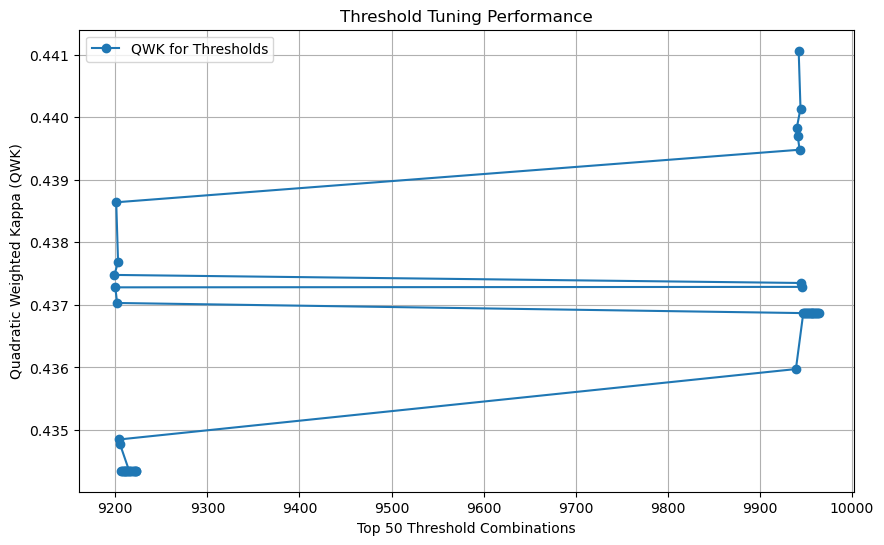

[0.60160294 1.0514105  2.71777567]


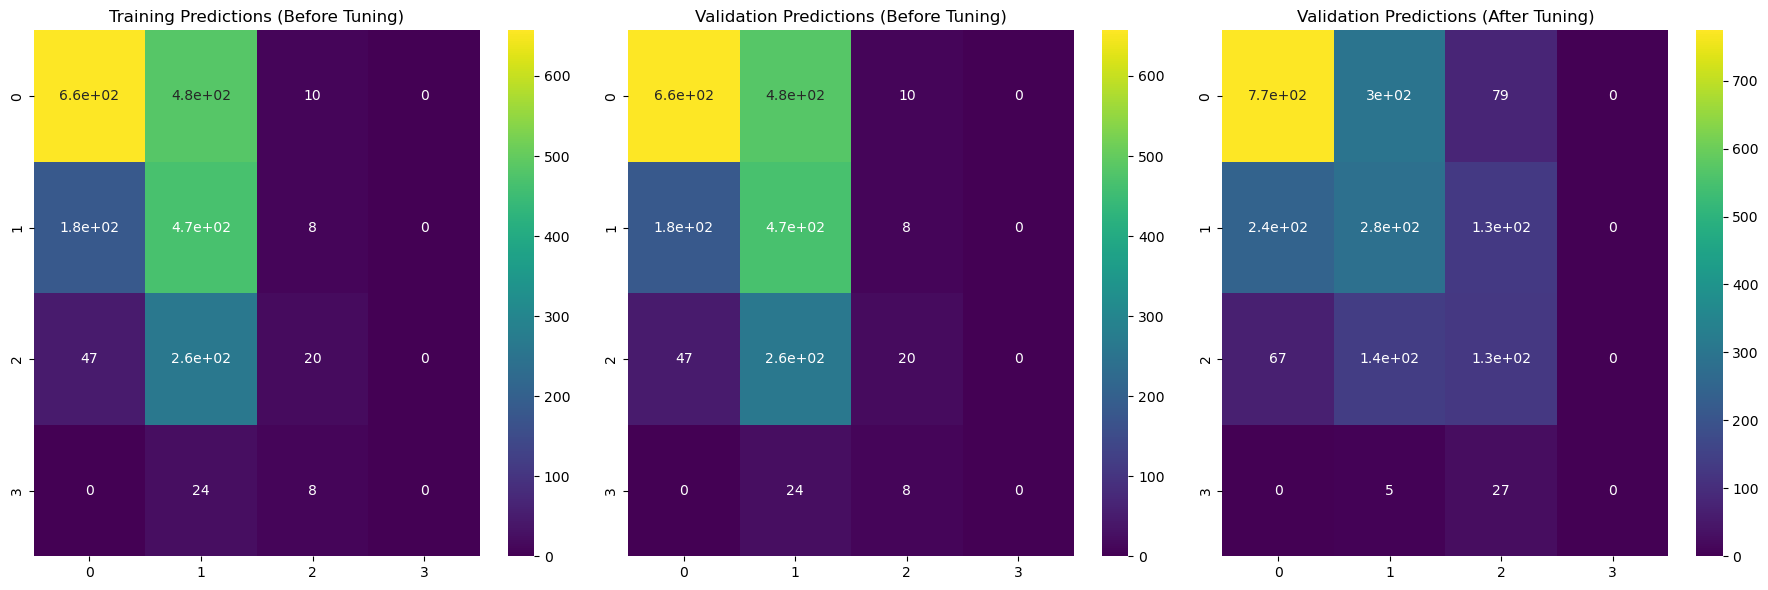

In [27]:
from sklearn.ensemble import VotingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.impute import KNNImputer

# Define parameters for each model
xgb_params = {
    'learning_rate': 0.05,
    'max_depth': 3,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1, 
    'reg_lambda': 5, 
    'random_state': 42
}

rf_params = {
     'bootstrap': True,
     'criterion': 'squared_error',
     'max_depth': 8,
     'max_features': None,
     'min_samples_leaf': 5,
     'min_samples_split': 5,
     'n_estimators': 150,
     'random_state': 42
}

# Initialize the models
rf_reg = RandomForestRegressor(**rf_params)
xgb_reg = XGBRegressor(**xgb_params)

# Create a VotingRegressor with three models
voting_reg = VotingRegressor(estimators=[('rf', rf_reg), ('xgb', xgb_reg)])

# Load and prepare test data
test_data = pd.read_csv(working_dir + 'test.csv')
id_col = test_data['id']
test_data = transform(test_data)

# Train the VotingRegressor
result = trainModel(voting_reg, train_data, test_data)

# Prepare and save the output
output = pd.DataFrame({
    'id': id_col,
    'sii': result
})

output.to_csv(output_dir + 'submission.csv', sep=',', index=False)
